# Распознование надетых масок

In [ ]:
"""
Этот код предназначен для обнаружения и классификации того, носят ли люди маски или нет, в режиме реального времени с использованием обученной модели глубокого обучения.
Код использует каскадный классификатор Хаара для обнаружения лиц и загружает предварительно обученную модель для распознавания масок.
Модель применяется к каждой обнаруженной интересующей области лица (ROI), чтобы предсказать, присутствует ли маска или нет.
Результат отображается в видеопотоке с ограничивающими рамками и метками с указанием «Маска» или «Без маски», а также процентом достоверности.
Код непрерывно захватывает кадры с веб-камеры, применяет распознавание и классификацию лиц и отображает обработанное видео с результатами в реальном времени.
"""

## Скачивание моделей

In [1]:
import os

is_models = False
for root, dirs, files in os.walk("."):  # Перебираем директории и файлы в текущем пути
    if root.endswith("models"):  # Если путь заканчивается на "models"
        is_models = True  # Устанавливаем флаг, что есть папка "models"
        break  # Прерываем цикл, так как условие уже выполнено

if not is_models:  # Если флаг "models" не установлен
    !wget -O "./models/mask_recog.h5" https://github.com/peaceful-djony/mipt_hackathon_1/blob/main/models/mask_recog.h5?raw=true  # Скачиваем файл mask_recog.h5 из GitHub
    !wget -O "./models/keras_model.h5" https://github.com/peaceful-djony/mipt_hackathon_1/blob/main/models/keras_model.h5?raw=true  # Скачиваем файл keras_model.h5 из GitHub
else:  # Если флаг "models" установлен
    print("Models already downloaded")  # Выводим сообщение: "Модели уже загружены"

Models already downloaded


## Настройка классификатора для распознования лиц и предобученной модели определения надета ли маска

In [2]:
from tensorflow.keras.saving import load_model
import cv2

# Загрузка предобученной модели обнаружения лиц
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
# Задание имени загружаемой модели
model_name = "mask_recog" # mask_recog vs keras_model
model_file_name = f"./models/{model_name}.h5"
# Загрузка предобученной модели распознавания масок
model = load_model(model_file_name, compile=False)

## Функция определния лиц и наличия на них масок 

In [3]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Функция для обнаружения лиц и классификации ношения маски
def detect_faces(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Преобразуем цветное изображение в оттенки серого
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(60, 60))  # Обнаруживаем лица с помощью каскада Хаара

    face_detected_flag = False  # Флаг, указывающий на обнаружение лица
    mask_detected_flag = False  # Флаг, указывающий на обнаружение маски

    for (x, y, w, h) in faces:  # Перебираем найденные лица
        face_detected_flag = True  # Устанавливаем флаг, что лицо обнаружено
        face_roi = gray[y:y+h, x:x+w]  # Область интереса (ROI) - лицо
        face_roi = cv2.resize(face_roi, (100, 100))  # Изменяем размер области интереса для классификации

        face_roi = cv2.cvtColor(face_roi, cv2.COLOR_BGR2RGB)  # Преобразуем цветовое пространство из BGR в RGB
        face_roi = cv2.resize(face_roi, (224, 224))  # Изменяем размер области интереса для модели
        face_roi = img_to_array(face_roi)  # Преобразуем изображение в массив
        face_roi = np.expand_dims(face_roi, axis=0)  # Добавляем размерность в массиве
        face_roi = preprocess_input(face_roi)  # Подготавливаем изображение для входа в модель

        preds = model.predict(face_roi)  # Классифицируем изображение с помощью модели
        for pred in preds:  # Перебираем предсказанные классы
            (mask, withoutMask) = pred
            is_mask = mask > withoutMask  # Проверяем, надета ли маска
            if is_mask:
                mask_detected_flag = True  # Устанавливаем флаг, что маска обнаружена
            label = "Маска" if is_mask else "Без маски"  # Определяем подпись для класса
            color = (0, 255, 0) if is_mask else (0, 0, 255)  # Определяем цвет для отображения
            label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)  # Форматируем подпись с вероятностью
            cv2.putText(image, label, (x, y- 10), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)  # Выводим подпись на изображении
            cv2.rectangle(image, (x, y), (x + w, y + h),color, 3)  # Рисуем прямоугольник вокруг лица на изображении
            
    return face_detected_flag, mask_detected_flag  # Возвращаем флаги обнаружения лица и маски

## Определение наличия масок на тестовых картинках

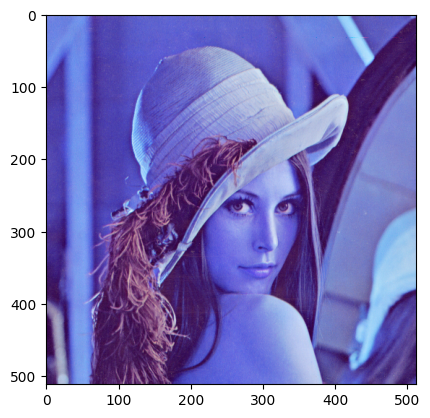

1/1 [==============================] - 0s 386ms/step


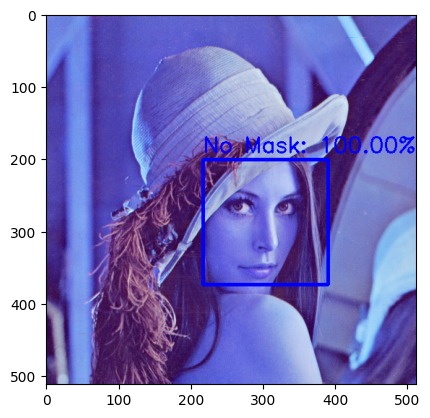

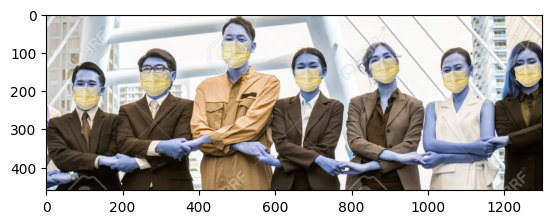

1/1 [==============================] - 0s 23ms/step


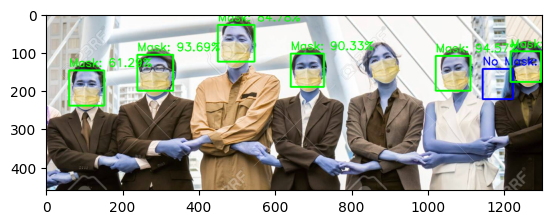

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

def display_face_detection_result(file_name):
    im = cv2.imread(file_name, cv2.IMREAD_UNCHANGED)  # Загружаем изображение
    plt.imshow(im)  # Отображаем изображение
    plt.show()  # Показываем изображение
    detect_faces(im)  # Вызываем функцию для обнаружения лиц
    plt.imshow(im)  # Отображаем изображение с результатами обнаружения
    plt.show()  # Показываем изображение

test_image_file = "./data/images/elena.png"  # Путь к тестовому изображению
display_face_detection_result(test_image_file)  # Вызываем функцию для отображения результатов обнаружения лиц

test_image_file = "./data/images/1.jpg"  # Путь к тестовому изображению
display_face_detection_result(test_image_file)  # Вызываем функцию для отображения результатов обнаружения лиц

## Запуск распознования из видео файла
оригинал файла взят с https://www.youtube.com/watch?v=EeuneefPTyY

In [29]:
import cv2

video_file_name = "./data/videos/Hong_Kong.mp4"
# Получение видео с файла
video_capture = cv2.VideoCapture(video_file_name)

while True:
    # Захват фрейма
    ret, frame = video_capture.read()

    # Обнаружение лиц
    detect_faces(frame)

    # Отображение текущего кадра
    cv2.imshow('Video', frame)

    # Нажмите 'q' для выхода
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Освобождение захвата видео и закрытие окон
video_capture.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 52ms/step


## Запуск распознования с веб-камеры

In [30]:
import cv2

# Получение видео с веб-камеры
video_capture = cv2.VideoCapture(0)

while True:
    # Захват фрейма
    ret, frame = video_capture.read()

    # Обнаружение лиц
    detect_faces(frame)

    # Отображение текущего кадра
    cv2.imshow('Video', frame)

    # Нажмите 'q' для выхода
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Освобождение захвата видео и закрытие окон
video_capture.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 61ms/step


## Описание кода по блокам

1. Импортируется модуль `os` для работы с операционной системой.

2. Устанавливается флаг `is_models` в значение `False`.

3. В цикле `for` происходит перебор директорий и файлов в текущем пути. Если какая-либо из директорий заканчивается на "models", то устанавливается флаг `is_models` в значение `True` и цикл прерывается.

4. Если флаг `is_models` не установлен, то происходит скачивание двух файлов `mask_recog.h5` и `keras_model.h5` из GitHub с помощью команд `!wget`.

5. Если флаг `is_models` установлен, выводится сообщение "Models already downloaded" (Модели уже загружены).

6. Импортируются модули `load_model` из пакета `tensorflow.keras.saving` и `cv2` для загрузки модели обнаружения лиц и работы с изображениями.

7. Загружается предобученная модель обнаружения лиц с помощью `CascadeClassifier` из файла `haarcascade_frontalface_default.xml`.

8. Задается имя загружаемой модели (`mask_recog` или `keras_model`) и формируется путь к файлу модели.

9. Загружается предобученная модель распознавания масок с помощью `load_model`.

10. Импортируются модули `numpy` и `img_to_array`, `preprocess_input` из пакета `tensorflow.keras.preprocessing.image`.

11. Определяется функция `detect_faces`, которая принимает изображение, выполняет обнаружение лиц, классификацию ношения маски и возвращает флаги обнаружения лица и маски.

12. Внутри функции `detect_faces` изображение преобразуется в оттенки серого. Затем с помощью каскада Хаара обнаруживаются лица на изображении.

13. Для каждого найденного лица выполняются следующие действия:
    - Устанавливается флаг `face_detected_flag` в значение `True`.
    - Выделяется область интереса (ROI) - лицо.
    - Область интереса изменяется в размере для подготовки к классификации.
    - Область интереса преобразуется в цветовое пространство RGB и изменяется в размере для подготовки к модели.
    - Область интереса преобразуется в массивы и подготавливается для входа в модель.
    - Используется модель для классификации изображения.
    - Перебираются предсказанные классы, определяется надета ли маска и устанавливается флаг `mask_detected_flag`.
    - Формируется подпись и цвет для отображения.
    - На изображении выводится подпись и рисуется прямоугольник вокруг лица.

14. Функция `display_face_detection_result` загружает изображение, отображает его, вызывает функцию `detect_faces`, отображает изображение с результатами обнаружения лиц.

15. Задается путь к тестовому изображению `test_image_file` и вызывается функция `display_face_detection_result` для отображения результатов обнаружения лиц на тестовом изображении.

16. Импортируется модуль `cv2` еще раз для работы с видео.

17. Захватывается видео с веб-камеры с помощью `VideoCapture`.

18. В цикле `while` происходит следующее:
    - Захватывается фрейм видео.
    - Выполняется обнаружение лиц на фрейме.
    - Отображается текущий кадр.
    - Если нажата клавиша 'q', то цикл прерывается.

19. Освобождается захват видео и закрываются окна.

